# Amazon TV Reviews Analysis

This notebook analyzes the reviews for different TV models to extract insights about customer satisfaction, sentiment trends, and common themes in feedback.

## Table of Contents
1. [Data Loading & Preprocessing](#data-loading--preprocessing)
2. [Rating Distribution Analysis](#rating-distribution-analysis)
3. [Sentiment Analysis](#sentiment-analysis)
4. [Time Trend Analysis](#time-trend-analysis)
5. [Word Clouds & N-grams Analysis](#word-clouds--n-grams-analysis)
6. [Aspect-Based Sentiment Analysis](#aspect-based-sentiment-analysis)
7. [Topic Modeling](#topic-modeling)

Goals & Insights
• Rating distribution by product
• Sentiment polarity & subjectivity vs star rating
• Time trends (are scores improving or declining?)
• Most common words/phrases in 1★ vs 5★ reviews (word clouds, n‑grams)
• Aspect‑based sentiment (UI, picture, sound, remote, reliability, setup…)
• Topic modeling (LDA) to surface emerging themes
• Correlation of “helpful_count” with sentiment/length
• Classification: can we predict star rating from text?


## Data Loading & Preprocessing

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path
import re
from datetime import datetime
import warnings

# For text analysis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

# For topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# For visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set up plotting style
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.data.path.append('/Users/khajievroma/nltk_data')

[nltk_data] Error loading punkt: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1018)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1018)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1018)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1018)>


In [30]:
# Load all CSV files from the reviews folder
review_files = glob('reviews/reviews_asin_*.csv')
print(f"Found {len(review_files)} review files: {review_files}")

# Dictionary to store product names and their corresponding dataframes
dfs = {}

# Process each file
for file_path in review_files:
    # Extract ASIN from filename
    asin_match = re.search(r'reviews_asin_([A-Z0-9]+)', file_path)
    if asin_match:
        asin = asin_match.group(1)
        
        # Load the data
        df = pd.read_csv(file_path)
        
        # Get product name from the file (or use ASIN if no name available)
        if 'product_title' in df.columns and not df['product_title'].empty:
            product_name = df['product_title'].iloc[0]
        else:
            # Use the product model and region from filename if available
            model_region_match = re.search(r'Product_model__(.+?)__', file_path)
            if model_region_match:
                product_name = f"Model: {model_region_match.group(1)}"
            else:
                product_name = f"ASIN: {asin}"
        
        # Add product name column
        df['product_name'] = product_name
        
        # Store in dictionary
        dfs[asin] = df
        
        print(f"Loaded {product_name} with {len(df)} reviews")
    else:
        print(f"Could not extract ASIN from filename: {file_path}")

# Combine all dataframes into one
all_reviews = pd.concat(dfs.values(), ignore_index=True) if dfs else pd.DataFrame()

# Basic data cleaning
if not all_reviews.empty:
    all_reviews['date'] = pd.to_datetime(all_reviews['date'])
    all_reviews['rating'] = pd.to_numeric(all_reviews['rating'], errors='coerce')
    all_reviews['text'] = all_reviews['text'].fillna('')

    # Display basic info
    print(f"\nTotal reviews: {len(all_reviews)}")
    print(f"Date range: {all_reviews['date'].min()} to {all_reviews['date'].max()}")
    print(f"Rating range: {all_reviews['rating'].min()} to {all_reviews['rating'].max()}")

    # Show the first few rows
    all_reviews.head()
else:
    print("No reviews data loaded.")

Found 11 review files: ['reviews/reviews_asin_B0DLGQDGF8_Product_model__L018___Region__.csv', 'reviews/reviews_asin_B0DPFBTX13_Product_model__HY320___Region_.csv', 'reviews/reviews_asin_B0DL58CSML_Product_model__HY450___Region_.csv', 'reviews/reviews_asin_B0DP4PS3ZS_Product_model__HY450___Region_.csv', 'reviews/reviews_asin_B0DL4Z4MFN_Product_model__L018___Region__.csv', 'reviews/reviews_asin_B0DHKDN7Q1_Product_model__HY320___Region_.csv', 'reviews/reviews_asin_B0DMZQ2311_Product_model__L018___Region__.csv', 'reviews/reviews_asin_B0DMZWQYWH_Product_model__HY450___Region_.csv', 'reviews/reviews_asin_B0DJX49NFR_Product_model__HY320___Region_.csv', 'reviews/reviews_asin_B0DL58WD5M_Product_model__HY450___Region_.csv', 'reviews/reviews_asin_B0DLFQKCRP_Product_model__L018___Region__.csv']
Loaded Model: L018 with 34 reviews
Loaded Model: HY320 with 100 reviews
Loaded Model: HY450 with 29 reviews
Loaded Model: HY450 with 5 reviews
Loaded Model: L018 with 34 reviews
Loaded Model: HY320 with 100

In [31]:
# Function to get descriptive statistics for each product
def get_product_stats(dataframes):
    stats = []
    for product_name, df in dataframes.items():
        product_stats = {
            'Product': product_name,
            'Reviews': len(df),
            'Average Rating': df['rating'].mean(),
            'Rating Std Dev': df['rating'].std(),
            'Median Rating': df['rating'].median(),
            '% 5-Star': (df['rating'] == 5).mean() * 100,
            '% 1-Star': (df['rating'] == 1).mean() * 100,
            'Verified Purchase %': df['verified_purchase'].mean() * 100,
            'Avg Review Length': df['text'].str.len().mean(),
            'Earliest Review': df['date'].min(),
            'Latest Review': df['date'].max()
        }
        stats.append(product_stats)
    
    return pd.DataFrame(stats)

# Get and display product statistics
product_stats = get_product_stats(dfs)
product_stats

,Product,Reviews,Average Rating,Rating Std Dev,Median Rating,% 5-Star,% 1-Star,Verified Purchase %,Avg Review Length,Earliest Review,Latest Review
0,B0DLGQDGF8,34,4.529412,1.160859,5.0,79.411765,8.823529,73.529412,795.000000,"April 1, 2025","March 9, 2025"
1,B0DPFBTX13,100,4.010000,1.507523,5.0,60.000000,17.000000,90.000000,211.545455,"April 1, 2025","October 9, 2024"
2,B0DL58CSML,29,4.448276,1.020721,5.0,68.965517,3.448276,65.517241,1018.620690,"April 14, 2025","March 9, 2025"
3,B0DP4PS3ZS,5,4.800000,0.447214,5.0,80.000000,0.000000,60.000000,1232.400000,"February 11, 2025","March 16, 2025"
4,B0DL4Z4MFN,34,4.529412,1.160859,5.0,79.411765,8.823529,73.529412,795.000000,"April 1, 2025","March 9, 2025"
5,B0DHKDN7Q1,100,4.460000,1.104810,5.0,73.000000,6.000000,100.000000,163.051020,"August 12, 2024","September 9, 2024"
6,B0DMZQ2311,36,4.472222,1.055221,5.0,72.222222,5.555556,27.777778,918.055556,"April 6, 2025","March 6, 2025"
7,B0DMZWQYWH,5,4.800000,0.447214,5.0,80.000000,0.000000,60.000000,1232.400000,"February 11, 2025","March 16, 2025"
8,B0DJX49NFR,100,4.010000,1.507523,5.0,60.000000,17.000000,90.000000,211.545455,"April 1, 2025","October 9, 2024"
9,B0DL58WD5M,29,4.448276,1.020721,5.0,68.965517,3.448276,65.517241,1018.620690,"April 14, 2025","March 9, 2025"


## Rating Distribution Analysis

In [32]:
# Visualize rating distribution by product using Plotly
fig = px.histogram(
    all_reviews, 
    x='rating', 
    color='product_name',
    barmode='group',
    nbins=5,
    labels={'rating': 'Star Rating', 'count': 'Number of Reviews', 'product_name': 'Product'},
    title='Rating Distribution by Product',
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    bargap=0.2,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    height=500
)

fig.show()

<Figure size 1200x600 with 0 Axes>

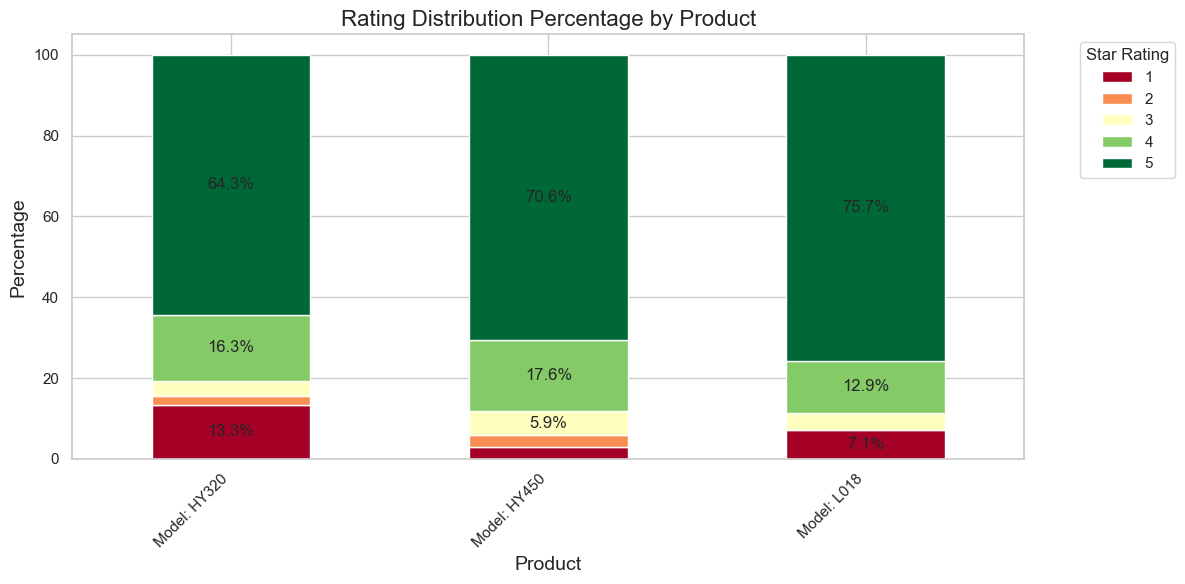

In [33]:
# Create a stacked percentage bar chart to compare proportions
rating_props = pd.crosstab(
    all_reviews['product_name'], 
    all_reviews['rating'], 
    normalize='index'
) * 100

# Plotting with seaborn
plt.figure(figsize=(12, 6))
ax = rating_props.plot(kind='bar', stacked=True, figsize=(12, 6), 
                      colormap='RdYlGn')

plt.title('Rating Distribution Percentage by Product', fontsize=16)
plt.xlabel('Product', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Star Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on bars
for container in ax.containers:
    labels = [f'{v:.1f}%' if v > 5 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')

plt.tight_layout()
plt.show()

## Sentiment Analysis

In [34]:
# Function to extract sentiment using TextBlob
def get_sentiment(text):
    blob = TextBlob(str(text))
    return {
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity
    }

# Apply sentiment analysis to all reviews
print("Calculating sentiment for all reviews...")
sentiments = all_reviews['text'].apply(get_sentiment)
all_reviews['polarity'] = sentiments.apply(lambda x: x['polarity'])
all_reviews['subjectivity'] = sentiments.apply(lambda x: x['subjectivity'])

# Display example of reviews with sentiment
sample = all_reviews[['product_name', 'rating', 'text', 'polarity', 'subjectivity']].sample(5)
sample

Calculating sentiment for all reviews...


,product_name,rating,text,polarity,subjectivity
79,Model: HY320,3,O projetor que recebi não é o original Magcubi...,0.375000,0.750000
316,Model: L018,5,High quality projector. I have it in the bedro...,0.310278,0.618611
485,Model: L018,5,I am not a projector expert and this is the fi...,0.392986,0.581944
396,Model: HY320,5,Linda imagem jogo no Xbox IPTV e strimers,0.000000,0.000000
167,Model: HY450,4,This 1080p projector comes with a reasonable s...,0.161962,0.397279


In [35]:
# Plot sentiment polarity vs star rating
fig = px.box(
    all_reviews, 
    x='rating', 
    y='polarity', 
    color='product_name',
    points='all',
    title='Sentiment Polarity vs Star Rating',
    labels={'rating': 'Star Rating', 'polarity': 'Sentiment Polarity (-1 to +1)', 'product_name': 'Product'}
)

fig.update_layout(
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    height=600,
    boxmode='group'
)

fig.show()

In [36]:
# Plot sentiment subjectivity vs star rating
fig = px.box(
    all_reviews, 
    x='rating', 
    y='subjectivity', 
    color='product_name',
    title='Sentiment Subjectivity vs Star Rating',
    labels={'rating': 'Star Rating', 'subjectivity': 'Subjectivity (0=Objective, 1=Subjective)', 'product_name': 'Product'}
)

fig.update_layout(
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    height=600,
    boxmode='group'
)

fig.show()

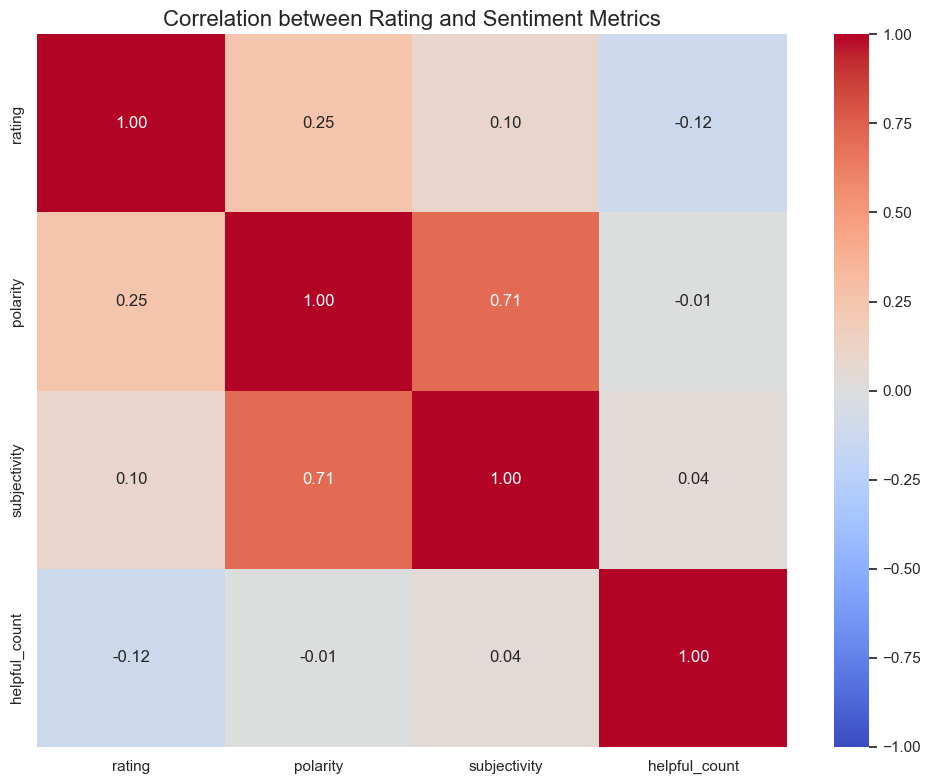

In [37]:
# Calculate correlation between rating and sentiment metrics
correlation = all_reviews[['rating', 'polarity', 'subjectivity', 'helpful_count']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation between Rating and Sentiment Metrics', fontsize=16)
plt.tight_layout()
plt.show()

## Time Trend Analysis

In [38]:
# Prepare data for time trend analysis
all_reviews['month_year'] = all_reviews['date'].dt.to_period('M')

# Group by month and product, and calculate average rating
monthly_avg = all_reviews.groupby(['month_year', 'product_name'])['rating'].mean().reset_index()
monthly_avg['month_year'] = monthly_avg['month_year'].astype(str)

# Plot time trends
fig = px.line(
    monthly_avg, 
    x='month_year', 
    y='rating', 
    color='product_name',
    markers=True,
    title='Average Rating Over Time by Product',
    labels={'month_year': 'Month', 'rating': 'Average Rating', 'product_name': 'Product'}
)

fig.update_layout(
    xaxis=dict(tickangle=45),
    yaxis=dict(range=[1, 5]),
    height=500
)

fig.show()

In [39]:
# Group by month and product, calculate average sentiment polarity
monthly_sentiment = all_reviews.groupby(['month_year', 'product_name'])[['polarity', 'subjectivity']].mean().reset_index()
monthly_sentiment['month_year'] = monthly_sentiment['month_year'].astype(str)

# Plot sentiment polarity over time
fig = px.line(
    monthly_sentiment, 
    x='month_year', 
    y='polarity', 
    color='product_name',
    markers=True,
    title='Average Sentiment Polarity Over Time by Product',
    labels={'month_year': 'Month', 'polarity': 'Average Sentiment Polarity', 'product_name': 'Product'}
)

fig.update_layout(
    xaxis=dict(tickangle=45),
    height=500
)

fig.show()

## Word Clouds & N-grams Analysis

In [40]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [41]:
# Apply preprocessing to review text
all_reviews['processed_text'] = all_reviews['text'].apply(preprocess_text)

# Create a function to generate word clouds
def generate_wordcloud(text, title, ax):
    custom_stopwords = STOPWORDS.union({'tv', 'television', 'sony', 'bravia'})
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=custom_stopwords, 
        colormap='viridis',
        max_words=100,
        contour_width=1,
        contour_color='steelblue'
    ).generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16)
    ax.axis('off')

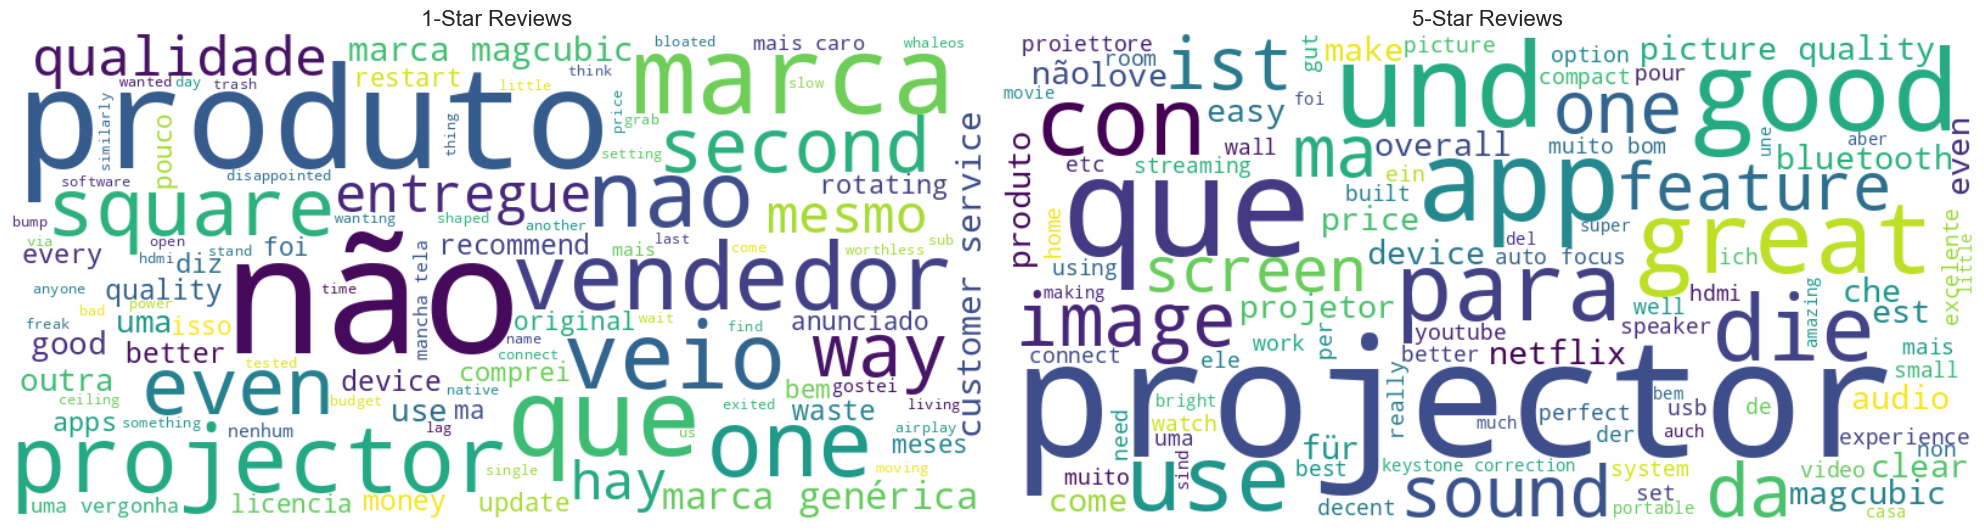

In [42]:
# Generate word clouds for 1-star and 5-star reviews
one_star_text = ' '.join(all_reviews[all_reviews['rating'] == 1]['processed_text'])
five_star_text = ' '.join(all_reviews[all_reviews['rating'] == 5]['processed_text'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
generate_wordcloud(one_star_text, '1-Star Reviews', ax1)
generate_wordcloud(five_star_text, '5-Star Reviews', ax2)
plt.tight_layout()
plt.show()

In [43]:
# Function to extract n-grams from text
def get_ngrams(texts, n=2, top_n=20):
    tokens = []
    for text in texts:
        tokens.extend([token for token in word_tokenize(text) if token.isalpha()])
    
    # Generate n-grams
    n_grams = list(ngrams(tokens, n))
    
    # Count frequency
    freq_dist = Counter(n_grams)
    
    # Get top n
    return freq_dist.most_common(top_n)

# Extract bigrams for 1-star and 5-star reviews
one_star_bigrams = get_ngrams(all_reviews[all_reviews['rating'] == 1]['processed_text'], n=2)
five_star_bigrams = get_ngrams(all_reviews[all_reviews['rating'] == 5]['processed_text'], n=2)

# Extract trigrams
one_star_trigrams = get_ngrams(all_reviews[all_reviews['rating'] == 1]['processed_text'], n=3, top_n=15)
five_star_trigrams = get_ngrams(all_reviews[all_reviews['rating'] == 5]['processed_text'], n=3, top_n=15)

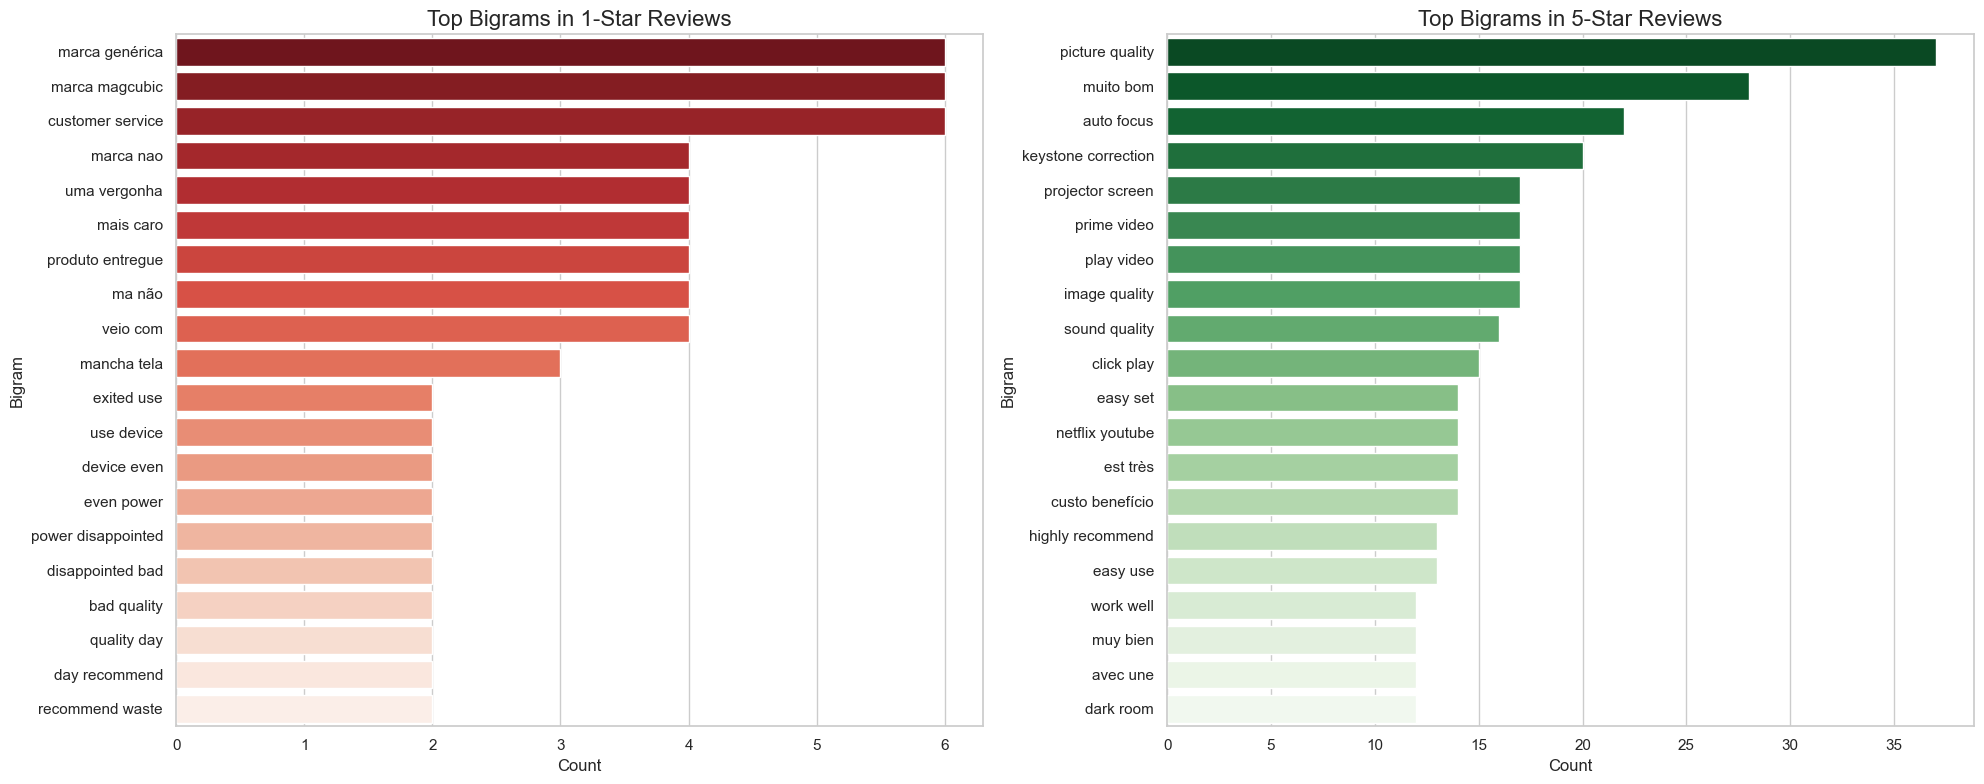

In [44]:
# Plot bigrams
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 1-star bigrams
one_star_bi_df = pd.DataFrame(one_star_bigrams, columns=['Bigram', 'Count'])
one_star_bi_df['Bigram'] = one_star_bi_df['Bigram'].apply(lambda x: ' '.join(x))
sns.barplot(data=one_star_bi_df, y='Bigram', x='Count', palette='Reds_r', ax=ax1)
ax1.set_title('Top Bigrams in 1-Star Reviews', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Bigram', fontsize=12)

# 5-star bigrams
five_star_bi_df = pd.DataFrame(five_star_bigrams, columns=['Bigram', 'Count'])
five_star_bi_df['Bigram'] = five_star_bi_df['Bigram'].apply(lambda x: ' '.join(x))
sns.barplot(data=five_star_bi_df, y='Bigram', x='Count', palette='Greens_r', ax=ax2)
ax2.set_title('Top Bigrams in 5-Star Reviews', fontsize=16)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Bigram', fontsize=12)

plt.tight_layout()
plt.show()

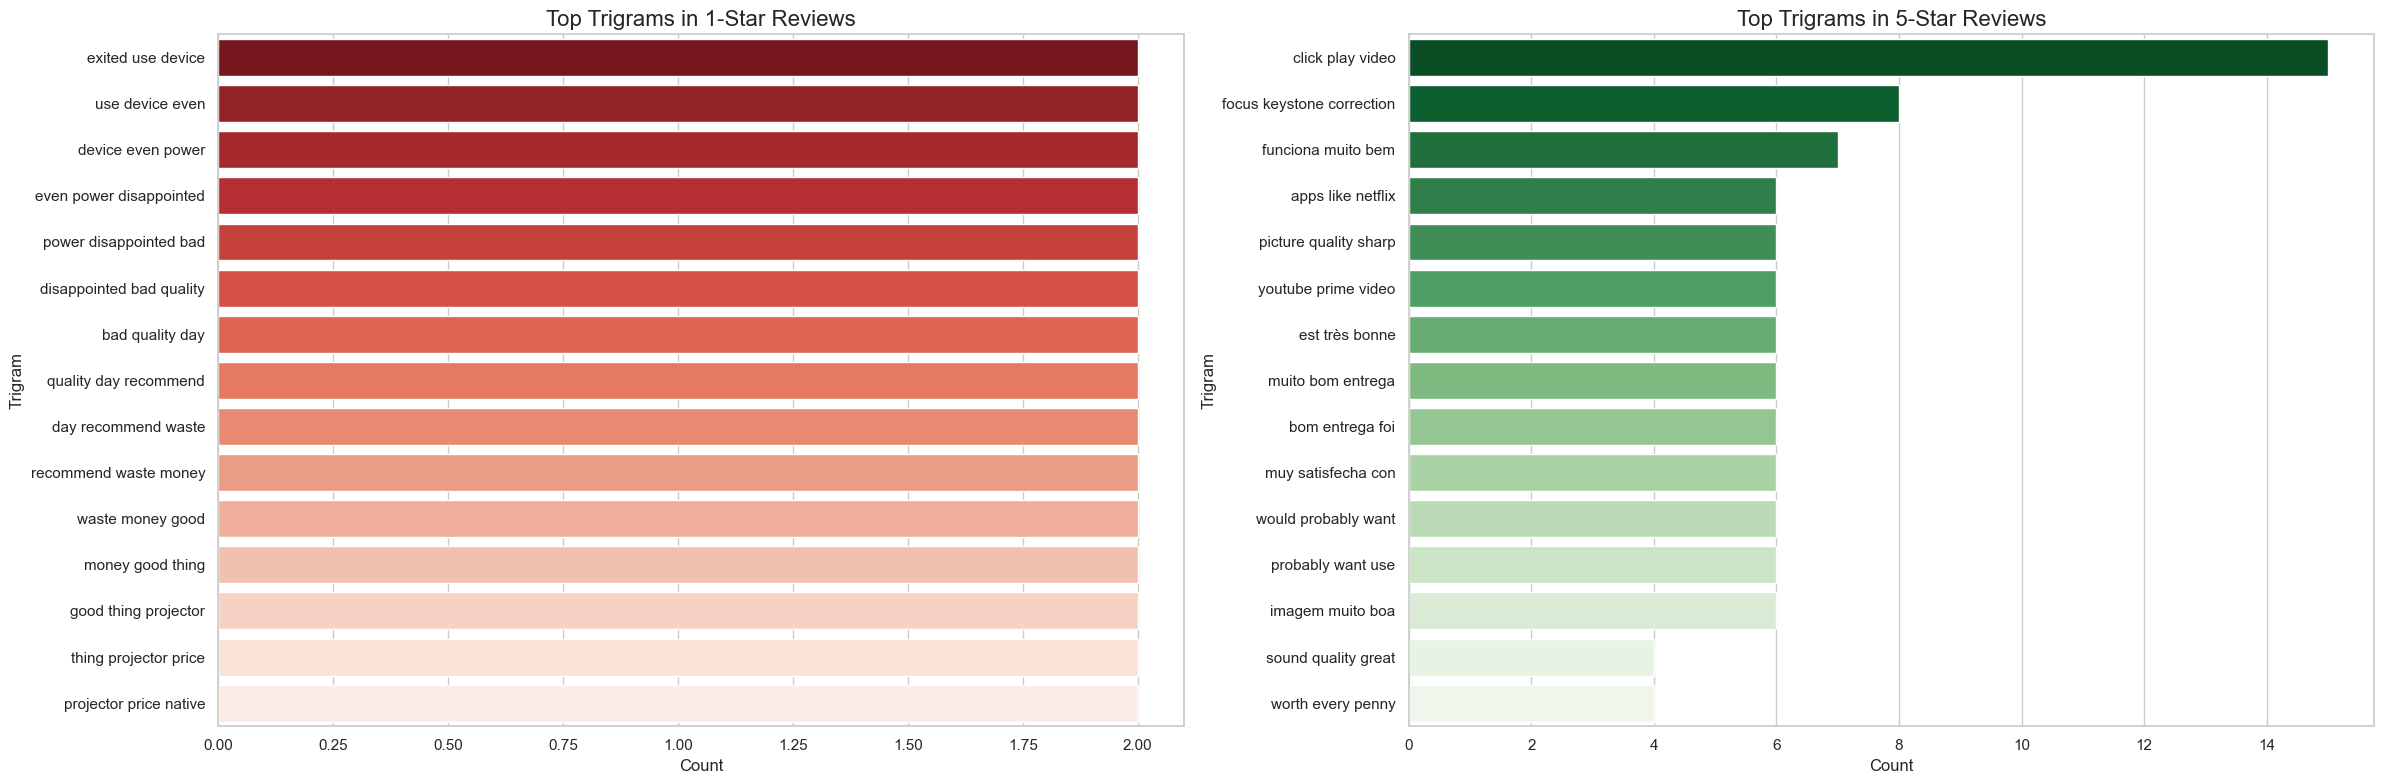

In [45]:
# Plot trigrams
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# 1-star trigrams
one_star_tri_df = pd.DataFrame(one_star_trigrams, columns=['Trigram', 'Count'])
one_star_tri_df['Trigram'] = one_star_tri_df['Trigram'].apply(lambda x: ' '.join(x))
sns.barplot(data=one_star_tri_df, y='Trigram', x='Count', palette='Reds_r', ax=ax1)
ax1.set_title('Top Trigrams in 1-Star Reviews', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Trigram', fontsize=12)

# 5-star trigrams
five_star_tri_df = pd.DataFrame(five_star_trigrams, columns=['Trigram', 'Count'])
five_star_tri_df['Trigram'] = five_star_tri_df['Trigram'].apply(lambda x: ' '.join(x))
sns.barplot(data=five_star_tri_df, y='Trigram', x='Count', palette='Greens_r', ax=ax2)
ax2.set_title('Top Trigrams in 5-Star Reviews', fontsize=16)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Trigram', fontsize=12)

plt.tight_layout()
plt.show()

## Aspect-Based Sentiment Analysis

In [46]:
# Define aspects of interest
aspects = {
    'picture': ['picture', 'image', 'display', 'screen', 'resolution', 'color', 'clarity', 'hdr'],
    'sound': ['sound', 'audio', 'speaker', 'volume', 'bass', 'noise', 'voice', 'dialogue'],
    'interface': ['interface', 'ui', 'menu', 'navigation', 'app', 'smart', 'google', 'roku'],
    'remote': ['remote', 'controller', 'button', 'control'],
    'setup': ['setup', 'install', 'connection', 'wifi', 'connect', 'pair'],
    'reliability': ['reliability', 'reliable', 'durable', 'longevity', 'last', 'fail', 'freeze', 'crash']
}

# Function to identify aspects in review text
def find_aspects(text, aspect_dict):
    text = text.lower()
    found_aspects = {}
    
    for aspect, keywords in aspect_dict.items():
        # For each aspect, check if any of its keywords are in the text
        for keyword in keywords:
            if keyword in text:
                found_aspects[aspect] = True
                break
    
    return found_aspects

# Apply aspect identification to all reviews
aspect_results = all_reviews['text'].apply(lambda x: find_aspects(str(x), aspects))

# Create columns for each aspect
for aspect in aspects.keys():
    all_reviews[f'has_{aspect}'] = aspect_results.apply(lambda x: aspect in x)

In [47]:
# Calculate sentiment for each aspect
aspect_sentiment = pd.DataFrame()

for aspect in aspects.keys():
    # Filter reviews that mention this aspect
    aspect_reviews = all_reviews[all_reviews[f'has_{aspect}']]
    
    # Skip if no reviews mention this aspect
    if len(aspect_reviews) == 0:
        continue
        
    # Calculate average sentiment and rating
    avg_sentiment = aspect_reviews[['polarity', 'rating']].mean()
    
    # Calculate sentiment counts
    positive = (aspect_reviews['polarity'] > 0.2).sum()
    negative = (aspect_reviews['polarity'] < -0.2).sum()
    neutral = len(aspect_reviews) - positive - negative
    
    # Add to dataframe
    aspect_sentiment = pd.concat([aspect_sentiment, pd.DataFrame({
        'Aspect': [aspect],
        'Mentions': [len(aspect_reviews)],
        'Avg Polarity': [avg_sentiment['polarity']],
        'Avg Rating': [avg_sentiment['rating']],
        'Positive': [positive],
        'Neutral': [neutral],
        'Negative': [negative],
        'Pos %': [positive / len(aspect_reviews) * 100],
        'Neg %': [negative / len(aspect_reviews) * 100]
    })])

aspect_sentiment = aspect_sentiment.reset_index(drop=True)
aspect_sentiment = aspect_sentiment.sort_values('Avg Polarity')
aspect_sentiment

,Aspect,Mentions,Avg Polarity,Avg Rating,Positive,Neutral,Negative,Pos %,Neg %
3,remote,52,0.175367,4.615385,24,28,0,46.153846,0.000000
2,interface,270,0.210608,4.588889,143,125,2,52.962963,0.740741
5,reliability,17,0.219458,3.705882,13,4,0,76.470588,0.000000
0,picture,230,0.253157,4.586957,137,93,0,59.565217,0.000000
1,sound,130,0.264434,4.738462,91,39,0,70.000000,0.000000
4,setup,117,0.266069,4.641026,79,38,0,67.521368,0.000000


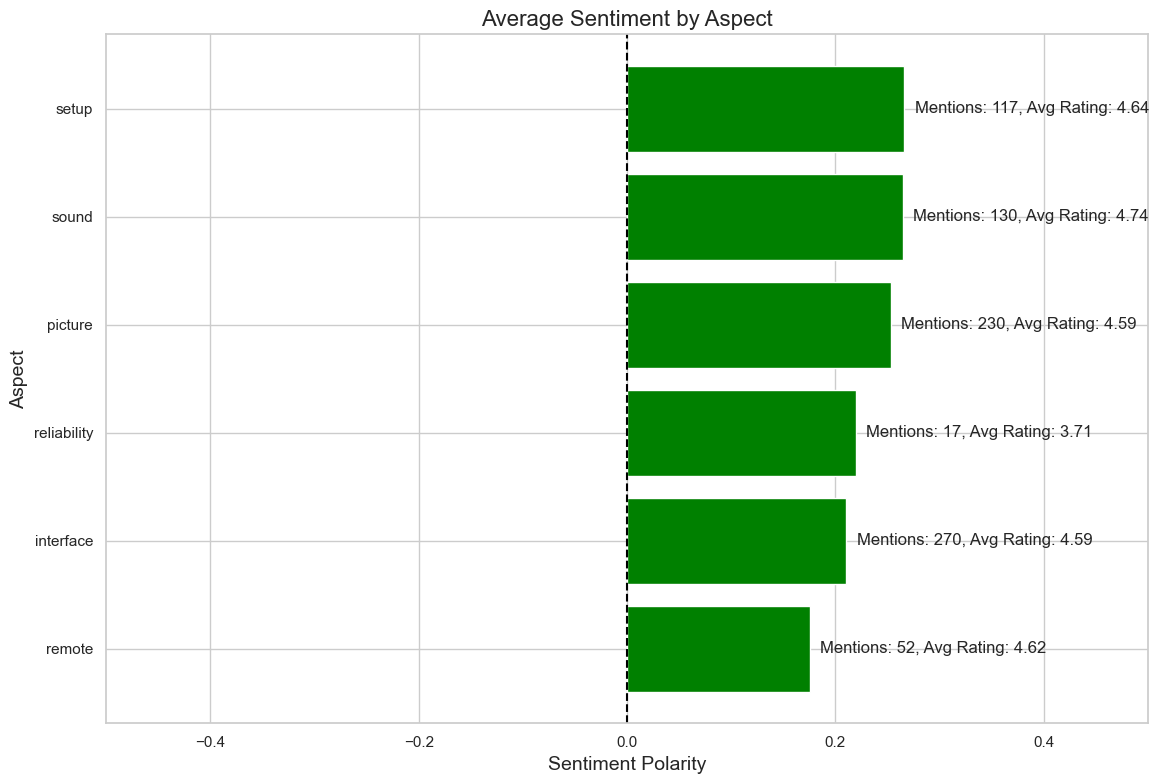

In [48]:
# Plot aspect sentiment
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(
    aspect_sentiment['Aspect'],
    aspect_sentiment['Avg Polarity'],
    color=aspect_sentiment['Avg Polarity'].apply(lambda x: 'green' if x > 0.1 else ('red' if x < -0.1 else 'gray'))
)

# Add labels
for i, bar in enumerate(bars):
    mentions = aspect_sentiment.iloc[i]['Mentions']
    rating = aspect_sentiment.iloc[i]['Avg Rating']
    ax.text(
        bar.get_width() + 0.01, 
        bar.get_y() + bar.get_height()/2, 
        f"Mentions: {mentions}, Avg Rating: {rating:.2f}",
        va='center'
    )

ax.set_title('Average Sentiment by Aspect', fontsize=16)
ax.set_xlabel('Sentiment Polarity', fontsize=14)
ax.set_ylabel('Aspect', fontsize=14)
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()

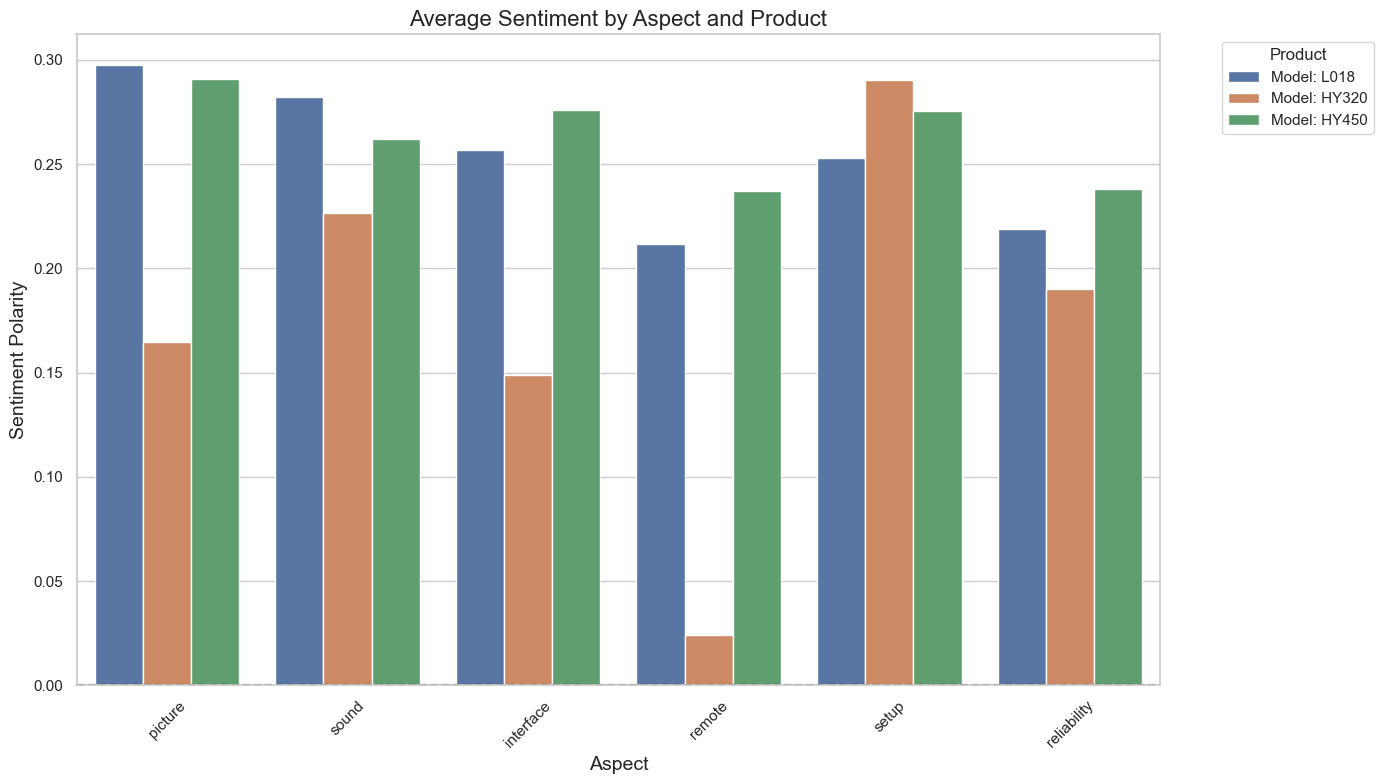

In [49]:
# Plot aspect sentiment comparison across products
aspect_product_sentiment = pd.DataFrame()

for aspect in aspects.keys():
    for product in all_reviews['product_name'].unique():
        # Filter reviews for this aspect and product
        filtered = all_reviews[(all_reviews[f'has_{aspect}']) & (all_reviews['product_name'] == product)]
        
        # Skip if no reviews mention this aspect for this product
        if len(filtered) == 0:
            continue
            
        # Calculate average sentiment
        avg_polarity = filtered['polarity'].mean()
        
        # Add to dataframe
        aspect_product_sentiment = pd.concat([aspect_product_sentiment, pd.DataFrame({
            'Aspect': [aspect],
            'Product': [product],
            'Mentions': [len(filtered)],
            'Avg Polarity': [avg_polarity]
        })])

aspect_product_sentiment = aspect_product_sentiment.reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=aspect_product_sentiment, x='Aspect', y='Avg Polarity', hue='Product')
plt.title('Average Sentiment by Aspect and Product', fontsize=16)
plt.xlabel('Aspect', fontsize=14)
plt.ylabel('Sentiment Polarity', fontsize=14)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Topic Modeling

In [50]:
# Prepare data for topic modeling
# Use TF-IDF vectorizer to get the most informative words
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    max_df=0.95,
    min_df=5
)

# Fit and transform the processed review texts
tfidf_matrix = tfidf_vectorizer.fit_transform(all_reviews['processed_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()